In [2]:
import torch
from sklearn.datasets import make_regression
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torchmetrics import Accuracy, Precision, Recall, ROC, F1Score

In [ ]:
class MSELoss:
    def __init__(self):
        self.y_pred = None
        self.y_true = None

    def forward(
        self,
        y_pred: torch.Tensor,
        y_true: torch.Tensor,
    ) -> torch.Tensor:
        assert y_pred.shape == y_true.shape, "Shapes of the tensors are not equal"
        self.y_pred = y_pred
        self.y_true = y_true

        return ((y_pred - y_true) ** 2).float().mean()

    def backward(self) -> torch.Tensor:
        # dinputs = df/dX
        assert self.y_pred is not None and self.y_true is not None
        batch_size = self.y_pred.size(0)
        self.dinputs = 2 * (self.y_pred - self.y_true) / batch_size

        return self.dinputs

In [4]:
class Neuron:
    def __init__(
        self, 
        n_inputs:int,
        n_outs:int=1
    ):
        self.weight = torch.randn(n_inputs, n_outs)
        self.bias = torch.randn(1, n_outs)

    def forward(self, inputs):
        self.inputs = inputs
        return inputs @ self.weight + self.bias

    def backward(self, dvalue:torch.Tensor, lr):
        assert hasattr(self, 'inputs'), 'Сначала нужно сделать вызов forward'
        dweights = self.inputs.T @ dvalue
        self.dbias = torch.sum(dvalue, axis = 0)
        self.weight -= lr * dweights
        self.bias -= lr * self.dbias
        return dvalue @ self.weight.T

In [5]:
class Linear:
    def __init__(
        self, 
        n_inputs:int,
        n_outs:int=1
    ):
        self.weight = torch.randn(n_inputs, n_outs)
        self.bias = torch.randn(1, n_outs)

    def forward(self, inputs):
        self.inputs = inputs        
        return inputs@self.weight + self.bias

    def backward(self, dvalue:torch.Tensor, lr):
        assert hasattr(self, 'inputs'), 'Сначала нужно сделать вызов forward'
        dweights = self.inputs.T @ dvalue
        self.dbias = torch.sum(dvalue, axis = 0)
        self.weight -= lr * dweights
        self.bias -= lr * self.dbias
        return dvalue @ self.weight.T

In [6]:
n_features = 4
n_samples = 1000

X, y, coef = make_regression(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=4,
    coef=True,
    bias=0.5,
    )

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [7]:
batch_size = 100
def split_into_batches(dataset, batch_size):
    num_batches = len(dataset) // batch_size
    batches = []
    
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        batch = dataset[start_idx:end_idx]
        batches.append(batch)
    
    # Handling the last batch which may have a smaller size
    if len(dataset) % batch_size != 0:
        last_batch = dataset[num_batches * batch_size:]
        batches.append(last_batch)
    
    return batches

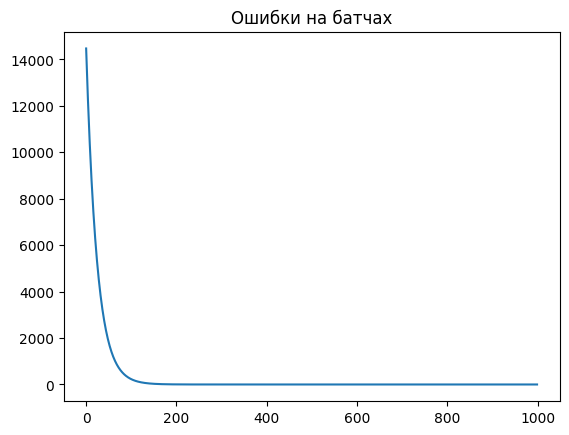

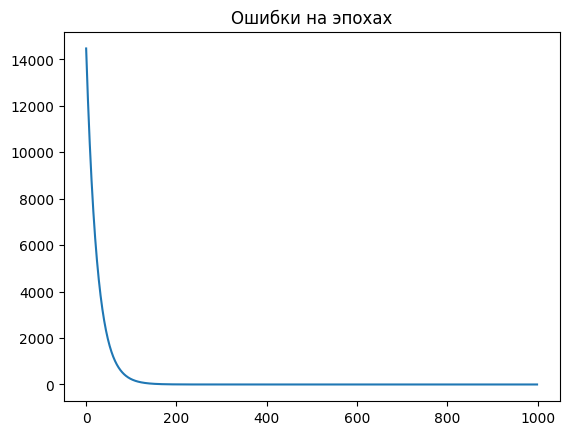

In [8]:
criterion = MSELoss()
learning_rate = 1e-2
num_epochs = 1000
batch_size = 100
dataset_X = split_into_batches(X, batch_size)
dataset_Y = split_into_batches(y, batch_size)
layer = Neuron(n_inputs=X.shape[1],n_outs=1)

losses_per_epoch = []
loss_vals = []

for _ in range(num_epochs):
    losses_in_epoch = []
    y_pred = layer.forward(X)

    loss_val = criterion.forward(y_pred=y_pred, y_true=y[:,None]).item()
    loss_vals.append(loss_val)
    losses_in_epoch.append(loss_val)

    dvalue = criterion.backward()
    layer.backward(dvalue, learning_rate)

    losses_per_epoch.append(float(np.mean(losses_in_epoch)))
    
plt.plot(loss_vals)
plt.title('Ошибки на батчах')
plt.show()
plt.plot(losses_per_epoch)
plt.title('Ошибки на эпохах')
plt.show()

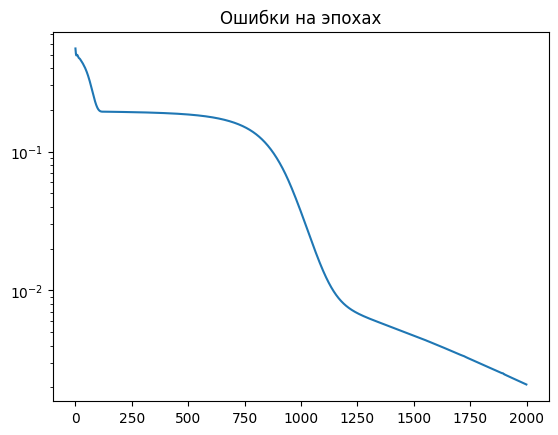

In [9]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size()) 

num_features= X.shape[1]
num_outs= y.shape[1]

class Model(nn.Module):
    def __init__(self, num_features, num_outputs) -> None:
        super().__init__()
        self.layer1 = nn.Linear(num_features, 10)
        self.relu = nn.Sigmoid()
        self.layer2 = nn.Linear(10, num_outputs)
    
    def forward(self, x:torch.Tensor)->torch.Tensor:
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x
    
model = Model(num_features=num_features, num_outputs=num_outs)
loss = nn.MSELoss()


lr = 1e-2
num_epochs = 2000

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

losses = []

for _ in range(num_epochs):
    pred = model.forward(X)
    loss_val = loss.forward(pred, y)
    loss_val.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    losses.append(loss_val.item())


plt.plot(losses)
plt.yscale('log')
plt.title('Ошибки на эпохах')
plt.show()

Accuracy  tensor(0.9100)
precision  tensor(0.)
recall  tensor(0.)
f1_score  tensor(0.)


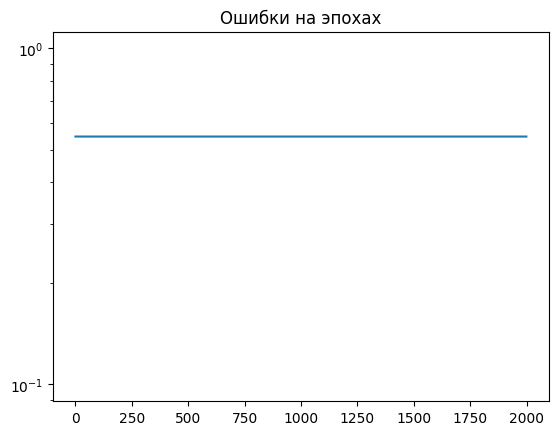

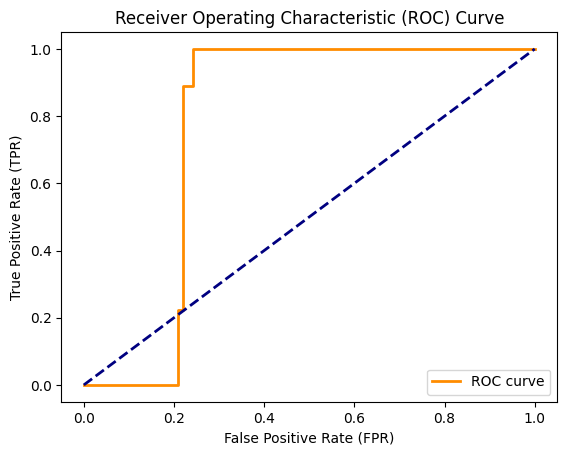

In [10]:
class Model(nn.Module):
    def __init__(self, num_features, num_outputs, num_epochs, x, y) -> None:
        super().__init__()
        self.X = x
        self.y = y
        self.layer1 = nn.Linear(num_features, 10)
        self.sigmoid = nn.Sigmoid()
        self.layer2 = nn.Linear(10, num_outputs)
        self.num_epochs = num_epochs
    
    def __forward(self, x:torch.Tensor)->torch.Tensor:
        x = self.layer1(x)
        x = self.sigmoid(x)
        x = self.layer2(x)
        return x
    
    def fit(self, lr = 1e-2, optimizer = False):
        self.losses = []
        loss = nn.MSELoss()
        if optimizer:
            optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        for _ in range(self.num_epochs):
            pred = self.__forward(self.X)
            loss_val = loss.forward(pred, self.y)
            loss_val.backward()
            if optimizer:
                optimizer.step()
                optimizer.zero_grad()
            
            self.losses.append(loss_val.item())
    
    def predict(self, x:torch.Tensor)->torch.Tensor:
        return self.__forward(x)
    
    def metrics(self, y_true, y_pred):
        plt.plot(self.losses)
        plt.yscale('log')
        plt.title('Ошибки на эпохах')
        plt.show
        # Инициализация метрик
        accuracy = Accuracy(task="binary")
        precision = Precision(task="binary")
        recall = Recall(task="binary")
        f1 = F1Score(task="binary")
        roc = ROC(task="binary")

        y_pred_labels = (y_pred > 0.5).float()
        y_true = y_true.long()
        # Вычисление метрик
        acc = accuracy(y_pred_labels, y_true)
        prec = precision(y_pred_labels, y_true)
        rec = recall(y_pred_labels, y_true)
        f1_score = f1(y_pred_labels, y_true)
        fpr, tpr, thresholds = roc(y_pred, y_true)
        print("Accuracy ", acc)
        print("precision ", prec)
        print("recall ", rec)
        print("f1_score ", f1_score)
        plt.figure()
        plt.plot(fpr.cpu().numpy(), tpr.cpu().numpy(), color='darkorange', lw=2, label='ROC curve')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Линия случайного классификатора
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()
    

model = Model(num_features=num_features, num_outputs=num_outs, num_epochs=2000, x=X, y=y)
model.fit()
y_pred = model.predict(X)
model.metrics(y_true=y, y_pred=y_pred)

In [11]:
import pandas as pd

In [12]:
column_names = [
    "class", "cap-shape", "cap-surface", "cap-color", "bruises", "odor",
    "gill-attachment", "gill-spacing", "gill-size", "gill-color",
    "stalk-shape", "stalk-root", "stalk-surface-above-ring",
    "stalk-surface-below-ring", "stalk-color-above-ring",
    "stalk-color-below-ring", "veil-type", "veil-color", "ring-number",
    "ring-type", "spore-print-color", "population", "habitat"
]

data = pd.read_csv('agaricus-lepiota.data', header=None, names=column_names)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [ ]:
print(data.info())
data.isnull().sum()
data.replace('?', pd.NA, inplace=True)
data.dropna(inplace=True)
data_encoded = pd.get_dummies(data, drop_first=True)
x = torch.tensor(data_encoded.drop("class_p", axis=1).values, dtype=torch.float32)
y = torch.tensor(data_encoded["class_p"].values, dtype=torch.float32)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [15]:
x.shape

torch.Size([5644, 76])

In [16]:
y.shape

torch.Size([5644])

In [17]:
num_features = x.shape[1]
num_outputs = 1

/Users/kshchavlev/Documents/itmo_projects/basic_ml/env/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([5644])) that is different to the input size (torch.Size([5644, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Accuracy  tensor(0.6180)
precision  tensor(0.)
recall  tensor(0.)
f1_score  tensor(0.)


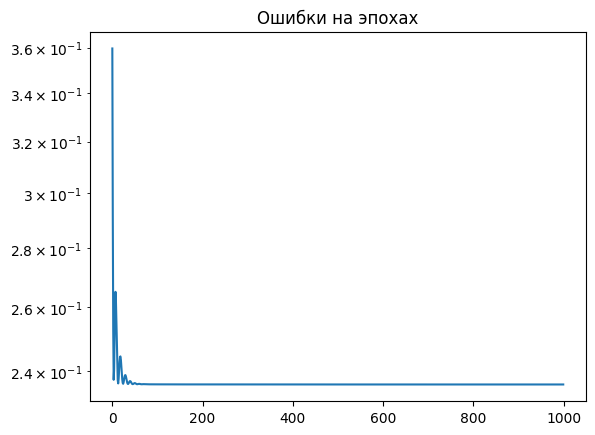

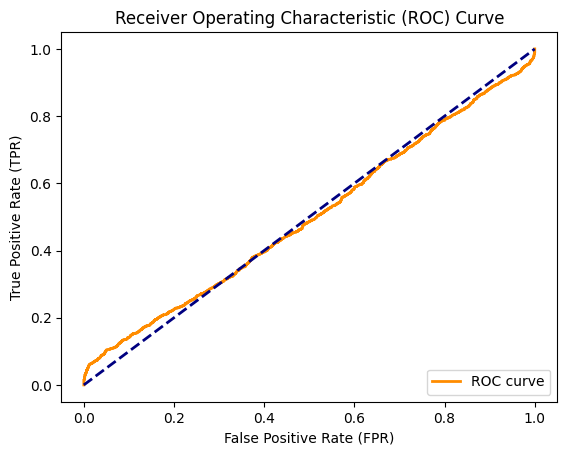

In [18]:
model1 = Model(num_features, num_outputs, 1000, x, y)
model1.fit(optimizer=True)
y_pred=model1.predict(x)
model1.metrics(y.squeeze(), y_pred.squeeze())

Accuracy  tensor(0.6180)
precision  tensor(0.)
recall  tensor(0.)
f1_score  tensor(0.)


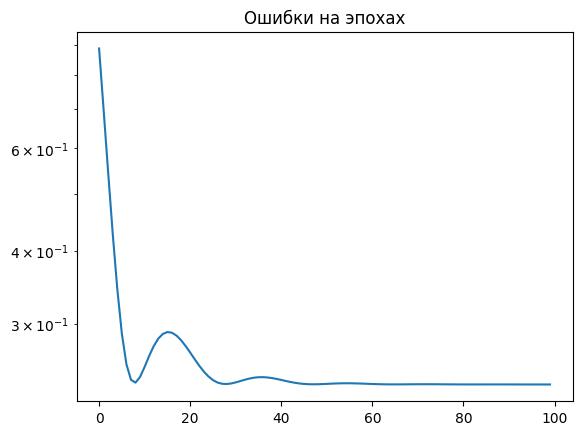

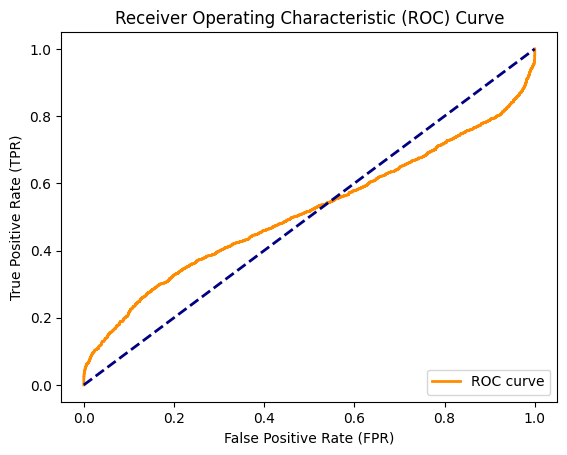

In [19]:
model2 = Model(num_features, num_outputs, 100, x, y)
model2.fit(optimizer=True)
y_pred=model2.predict(x)
model2.metrics(y.squeeze(), y_pred.squeeze())

Accuracy  tensor(0.3820)
precision  tensor(0.3820)
recall  tensor(1.)
f1_score  tensor(0.5528)


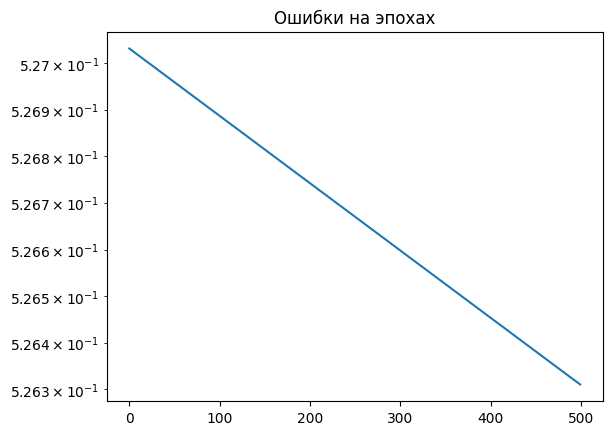

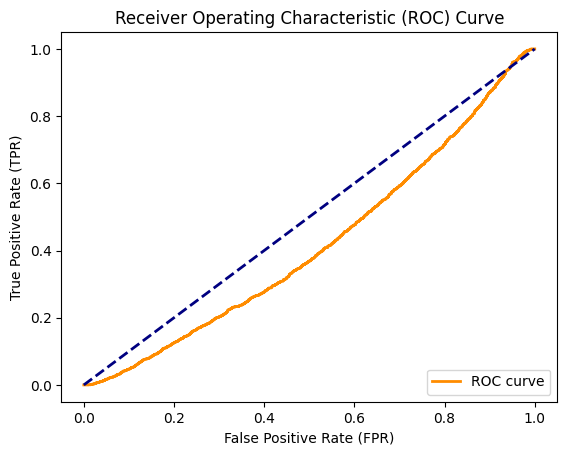

In [20]:
model3 = Model(num_features, num_outputs, 500, x, y)
model3.fit(lr=1e-7, optimizer=True)
y_pred=model3.predict(x)
model3.metrics(y.squeeze(), y_pred.squeeze())

Accuracy  tensor(0.6180)
precision  tensor(0.)
recall  tensor(0.)
f1_score  tensor(0.)


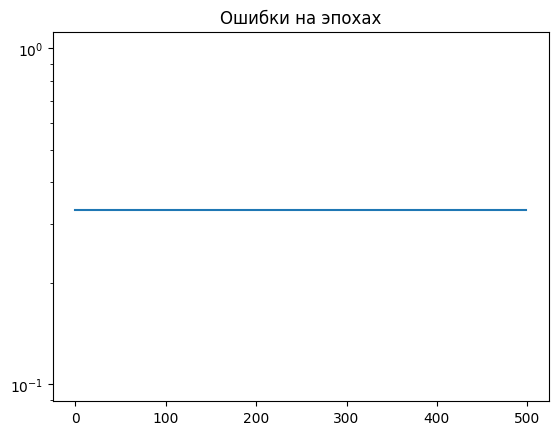

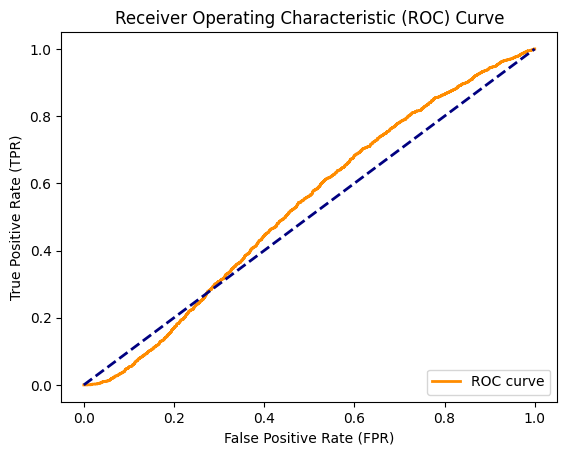

In [21]:
model4 = Model(num_features, num_outputs, 500, x, y)
model4.fit(lr=1e-7, optimizer=False)
y_pred=model4.predict(x)
model4.metrics(y.squeeze(), y_pred.squeeze())

Accuracy  tensor(0.6180)
precision  tensor(0.)
recall  tensor(0.)
f1_score  tensor(0.)


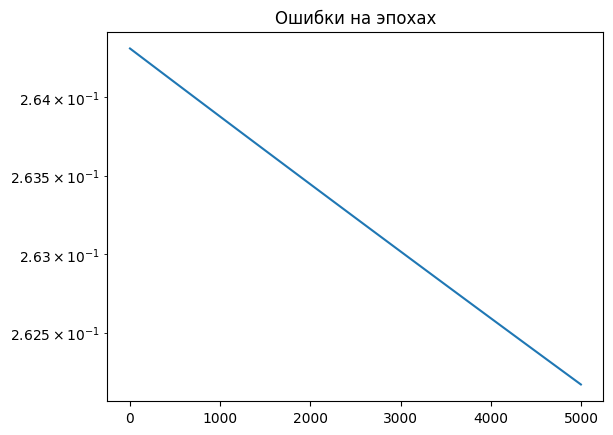

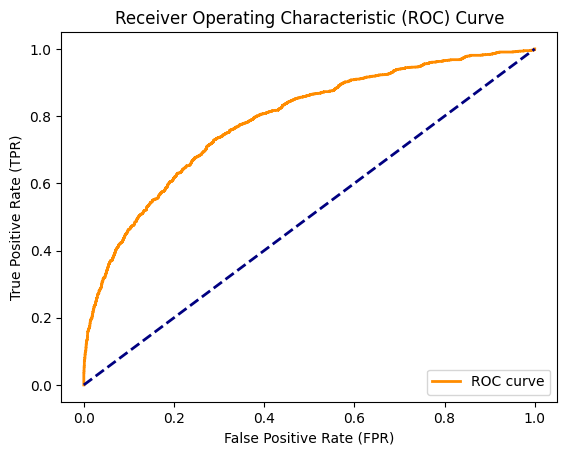

In [ ]:
model3 = Model(num_features, num_outputs, 50000, x, y)
model3.fit(lr=1e-7, optimizer=True)
y_pred=model3.predict(x)
model3.metrics(y.squeeze(), y_pred.squeeze())